# Imports

In [1]:
# !pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import gmean

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import gc

np.random.seed(42069)
warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
params = {
    'figure.figsize': (10, 5)
     }
plt.rcParams.update(params)

# Download Market Data

In [4]:
# This will download data from yahoo finance - more than enough for prototyping
df = yf.download(
        # tickers list or string as well
        tickers = "MGC=F",
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5y",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',
        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,
        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,
        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,
        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


In [5]:
df.shape

(1243, 5)

In [6]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-10-17,1256.599976,1256.599976,1254.400024,1254.400024,1
2016-10-18,1260.800049,1260.800049,1260.800049,1260.800049,2
2016-10-19,1275.800049,1276.000000,1267.900024,1267.900024,2
2016-10-20,1265.599976,1265.599976,1265.599976,1265.599976,3
2016-10-21,1265.900024,1265.900024,1265.900024,1265.900024,0


In [7]:
df['avg_price'] = gmean(df[['Open', 'High', 'Low', 'Close']], axis=1)

In [8]:
df.head()

,Open,High,Low,Close,Volume,avg_price
Date,,,,,,
2016-10-17,1256.599976,1256.599976,1254.400024,1254.400024,1,1255.499518
2016-10-18,1260.800049,1260.800049,1260.800049,1260.800049,2,1260.800049
2016-10-19,1275.800049,1276.000000,1267.900024,1267.900024,2,1271.893733
2016-10-20,1265.599976,1265.599976,1265.599976,1265.599976,3,1265.599976
2016-10-21,1265.900024,1265.900024,1265.900024,1265.900024,0,1265.900024


In [9]:
nullvaluecheck = pd.DataFrame(df.isna().sum().sort_values(ascending=False)*100/df.shape[0],columns=['missing %']).head(60)
nullvaluecheck.style.background_gradient(cmap='PuBu')

,missing %
Open,0.000000
High,0.000000
Low,0.000000
Close,0.000000
Volume,0.000000
avg_price,0.000000


In [10]:
returns = np.log(df['Close']).diff()
returns.dropna(inplace=True)

# EDA

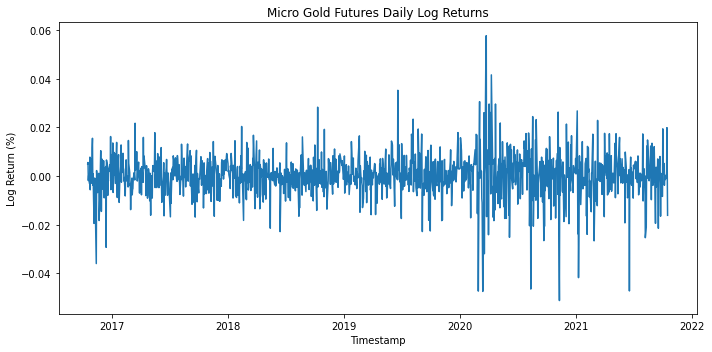

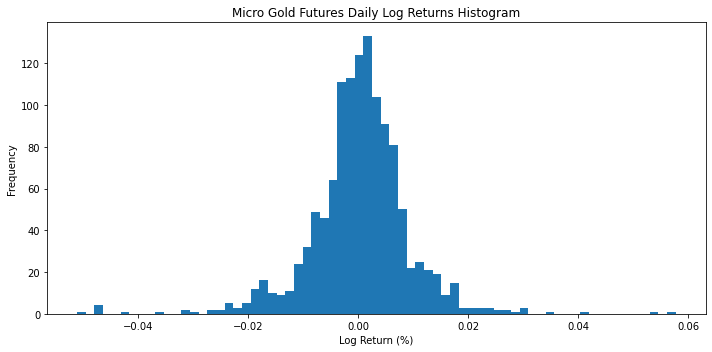

In [11]:
plt.figure()
plt.plot(returns)
plt.title('Micro Gold Futures Daily Log Returns')
plt.xlabel('Timestamp')
plt.ylabel('Log Return (%)')
plt.tight_layout()

plt.figure()
plt.hist(returns, bins='auto')
plt.title('Micro Gold Futures Daily Log Returns Histogram')
plt.ylabel('Frequency')
plt.xlabel('Log Return (%)')
plt.tight_layout()

In [12]:
# 70 - 30 Train Test
split = int(0.3*len(returns))
X = returns[:-split]
X_test = returns[-split:]

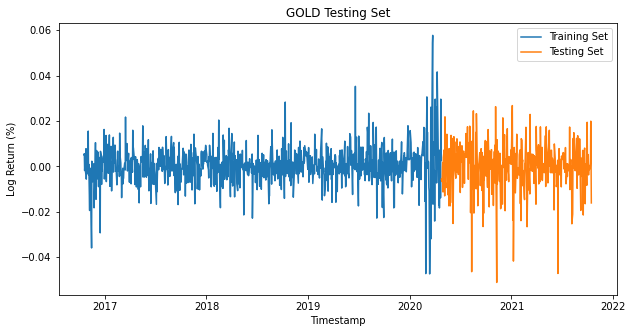

In [13]:
plt.plot(X, label='Training Set')
plt.plot(X_test, label='Testing Set')
plt.title(label='GOLD Testing Set')
plt.xlabel('Timestamp')
plt.ylabel('Log Return (%)')
plt.legend()
plt.show()

# Modelling

In [14]:
# !pip install hmmlearn

You should consider upgrading via the 'C:\Users\Elite_PC\anaconda3\python.exe -m pip install --upgrade pip' command.


In [15]:
from hmmlearn import hmm

In [16]:
X = X.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy().reshape(-1, 1)

In [17]:
model = hmm.GaussianHMM(
    # 2 States
    n_components=2,
    covariance_type="diag",
    verbose=True
)

In [18]:
%%time
model.fit(X)

Wall time: 65 ms


         1        2132.4945             +nan
         2        2893.7605        +761.2661
         3        2894.3138          +0.5533
         4        2897.6845          +3.3707
         5        2908.3958         +10.7112
         6        2923.2388         +14.8430
         7        2936.9910         +13.7522
         8        2949.2024         +12.2114
         9        2960.4303         +11.2279
        10        2970.7732         +10.3429


GaussianHMM(n_components=2, verbose=True)

In [27]:
# Adjust the probabilities for transitioning states
model.transmat_ = np.array(
    [
        [0.9, 0.1],
        [0.1, 0.9]
    ]
)

In [28]:
Z = model.predict(X_test)
Z_train = model.predict(X)

# Evaluation

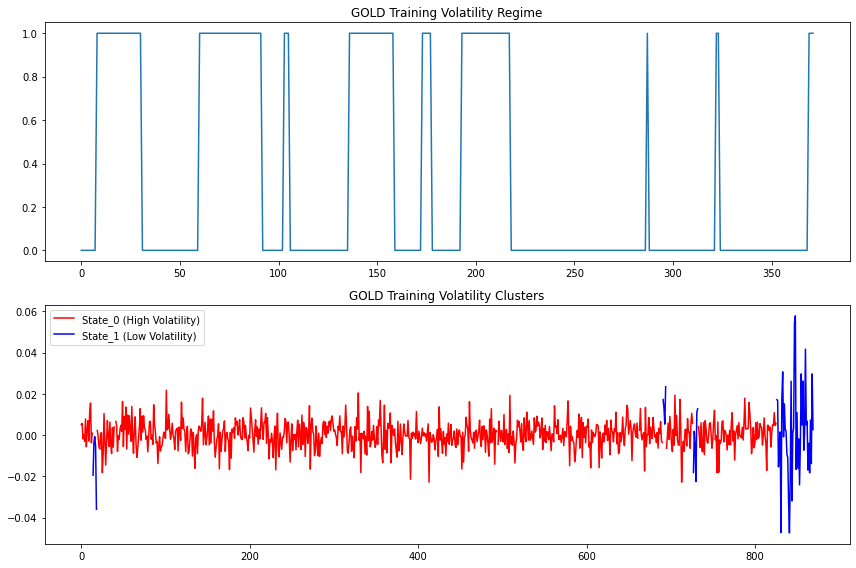

In [29]:
# Compute State Changes
returns_train0 = np.empty(len(Z_train))
returns_train1 = np.empty(len(Z_train))
returns_train0[:] = np.nan
returns_train1[:] = np.nan

# Create series for each state change
returns_train0[Z_train == 0] = returns[:-split][Z_train == 0]
returns_train1[Z_train == 1] = returns[:-split][Z_train == 1]


fig, ax = plt.subplots(figsize=(12,8))

# Plot the Volatility Regime and the states
plt.subplot(211)
plt.plot(Z)
plt.title(label='GOLD Training Volatility Regime')

plt.subplot(212)
plt.plot(returns_train0, label='State_0 (High Volatility)', color='r')
plt.plot(returns_train1, label='State_1 (Low Volatility)', color='b', )
plt.title(label='GOLD Training Volatility Clusters')
plt.legend()
plt.tight_layout()

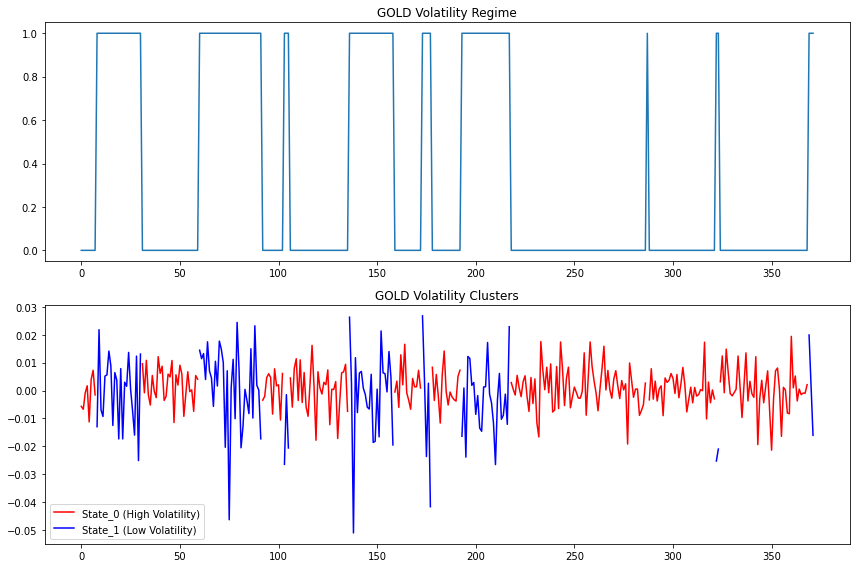

In [31]:
# Compute State Changes
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# Create series for each state change
returns0[Z == 0] = returns[-split:][Z == 0]
returns1[Z == 1] = returns[-split:][Z == 1]

# Plot the Volatility Regime and the states
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(211)
plt.plot(Z)
plt.title(label='GOLD Volatility Regime')

plt.subplot(212)
plt.plot(returns0, label='State_0 (High Volatility)', color='r')
plt.plot(returns1, label='State_1 (Low Volatility)', color='b')
plt.title(label='GOLD Volatility Clusters')

plt.legend()
plt.tight_layout()